# Ensemble methods

## Name: Benjamin Fraeyman

## Context

In this lab session we will build a classifier which can assist in diagnosing breast cancer. You will see that this task is relatively easy when you look at the error of your system but keep in mind that for a task like this, false negatives (saying someone is healthy while the person is not) are a very bad thing.

> $\textbf{Data}$ : As data we will use features extracted from a biopsy. What the actual features are is not so important, it is sufficient to know that they are derived from a digitized image of a breast mass.

> $\textbf{Outcome}$ : The goal of the classifier is to either say a certain cell is malignant (1) or benign (-1).  $\textbf{This is binary classification.}$


## Recap of the theory:

>Combining multiple classifiers or regression models into an 'ensemble model' can help to achieve a higher accuracy as opposed to training a single prediction model. Critical in the success of combining models is to have $\textbf{base learners}$ that are $\textbf{diverse}$, as there is no point in combining learners that make similar decisions.

>In this lab session we will explore two of many possible approaches to create $\textbf{diverse base models}$ and $\textbf{combine}$ them into an $\textbf{ensemble model}$.

>We will explore $\textbf{boosting}$, an approach in which base learners are constructed in such way that the next learner will focus on the mistakes of the previous learner(s), thus creating diversity. More specifically, we will implement a variant of the $\textbf{AdaBoost}$ algorithm.

> We will also briefly train an ensemble of decision trees using $\textbf{bagging.}$

## Part 1: Loading and looking at the data

First we will load the data and have a look at the characteristics.

In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

# Figures inline or interactive
%matplotlib inline
# %matplotlib
plt.style.use('ggplot')

# Load the data, make sure there is a 'data' folder containing the dataset in the same folder as this notebook
data = sio.loadmat('data/breastcancer.mat')

# This is the data we will use for training
train_data = data['train_data']
test_data = data['test_data']
train_labels = data['y_train']
test_labels = data['y_test']

# Question 1

Make some plots and perform some analysis of the input data before you start. It is important to get to know your data.

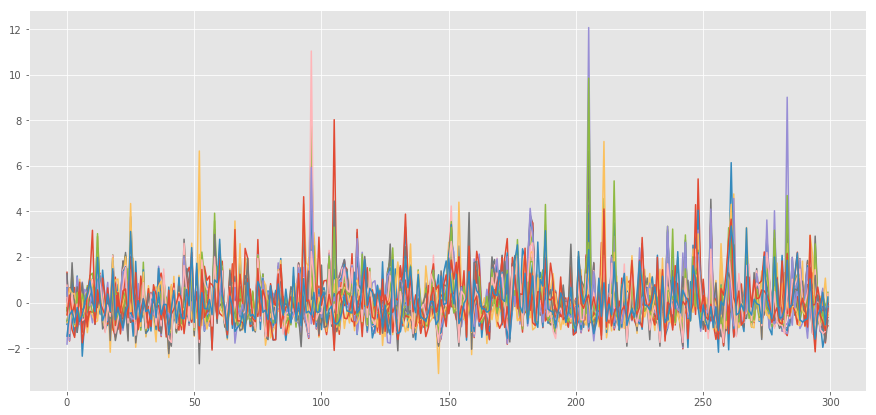

In [2]:
plt.rcParams["figure.figsize"] = [15,7]
plt.plot(train_data)
plt.show()

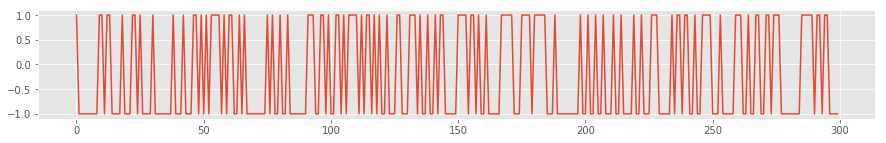

In [3]:
plt.rcParams["figure.figsize"] = [15,2]
plt.plot(train_labels)
plt.show()

> -1 -> 1

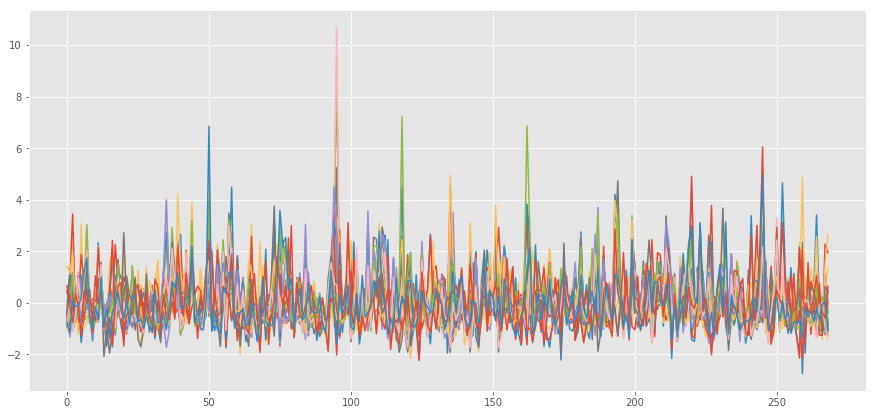

In [4]:
plt.rcParams["figure.figsize"] = [15,7]
plt.plot(test_data)
plt.show()

# Question 2

What are the dimensions of the training set and test set?

In [5]:
number_of_training_samples = train_data.shape[0]
number_of_test_samples = test_data.shape[0]
number_of_dimensions = train_data.shape[1]
number_of_dimensions2 = test_data.shape[1]
print('Training set size: {}'.format([number_of_training_samples,number_of_dimensions]))
print('Test set size:     {}'.format([number_of_test_samples,number_of_dimensions2]))
print('Control equal #dim:{}'.format([number_of_dimensions,number_of_dimensions2]))

Training set size: [300, 30]
Test set size:     [269, 30]
Control equal #dim:[30, 30]


## Using a very simple base learner: decision stumps

As a first step we will use a very simple base learner called a decision stump, which is a a 'weak learner'. Weak learners are defined as learners who perform only slightly better than random guessing and are computionally efficient. 

You will see that this classifier is not complex. It can only use 1 feature and it only creates a very simple decision boundary. Because of the (many) mistakes that are made by an individual weak learner, we will later create an ensemble model in the next part.

A decision stump will classify a certain sample as either -1 or 1 based on the fact if the value of a certain dimension is either > or < than a threshold. The dimension is an input parameter of the decision stump.

$f(x) = \left\{ 
\begin{array}{l l}
  1 & \quad \mbox{if $x>$ threshold}\\
  -1 & \quad \mbox{otherwise}\\ \end{array} \right.       ,  $
  
  
To use decision stumps we need two functions
  
>applying a decision stump (= make predictions)

>training a decision stump (= learn optimal threshold x for a certain dimension)
 
These functions are already implemented and it is not important to know how they work. Only which input parameters they need. However, have a look at how a decision stump makes prediction based on the plot below

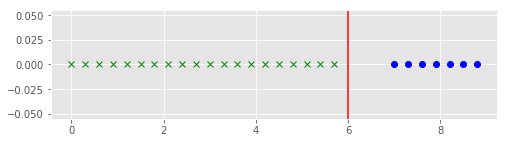

In [6]:
# The following figure illustrates how a decision stump with parameter 'threshold' does predictions. 
# The red line represents the decision boundary/threshold threshold
# Everything below the threshold is classified as 'x' , everything above threshold is classified as 'o'

# Select a random threshold for illustrative purposes
threshold= 6.0
# Define two example arrays on each side of the decision boundary
ar = np.arange(0.0,threshold,0.3) 
arr = np.arange(threshold+1,9.0,0.3)

plt.rcParams["figure.figsize"] = [8, 2]
# Plot the decision stump boundary 
plt.axvline(threshold, c='r')
# Plot how data points on each side of the decision boundary value threshold are classified differently
plt.plot(ar, np.zeros_like(ar) , 'x', c='g')
plt.plot(arr, np.zeros_like(arr) , 'o', c='b')
plt.show()

$\textbf{Applying a decision stump}$

In [7]:
# Function which applies a decision stump on vector x using a threshold 
# When using this method, each item in the vector x should correspond to a single feature value of the datapoints

# x : a vector containing a single feature value for each datapoint (length x == number of datapoints)
# threshold : decision boundary value
# return: this function returns the labels of the datapoints based on the prediction of the stump
def apply_stump(x,threshold):
    # Create vector of ones with the same length as vector x
    output = np.ones(np.shape(x))
    # Set everything below threshold to -1
    output[x < threshold] = -1
    # return the predictions
    return output

$\textbf{Training a decision stump}$

In [8]:
# This function 'trains' a decision stump on a vector x with corresponding labels y, with weights x
# Understanding how this training algorithm determines the optimal threshold
# is not important for the remainder of this lab session!!! 

# x : a vector containing the a single feature value for each datapoint (length x == number of datapoints)
# y : the label corresponding with each datapoint
# w : the weight currently paired with the datapoint indicating how important it is in the error function
# return : this function should return the optimal value threshold to minimize the weighted error
def train_stump (x,y,w):
    # The number of data points
    number_of_data_points = np.shape(x)[0]  
    # Init empty array with the same length as x
    sums = np.zeros(number_of_data_points)
    
    # Sort x, ascending, also return the indices    
    ind = np.argsort(x)
    x_sorted = x[ind]
    # Multiply the weight and the label of the first elemement in the sorted x
    sums[0] = w[ind[0]] * y[ind[0]]
    
    # Now continue to calculate the cumulative weighted sum along x
    for i in range(1,number_of_data_points):
        sums[i] = sums[i-1] + (w[ind[i]] * y[ind[i]])

    # Determine the extremum
    extremum_index = np.argmax(abs(sums))
    
    # If it's not the last element, split on the value between the two extremum, else just pick the extremum value
    if ((extremum_index+1) < number_of_data_points):
        threshold = (x_sorted[extremum_index] + x_sorted[extremum_index+1])  /2
    else:
        threshold = x_sorted[extremum_index]

    # Swap the sign if we found a minimum
    if (sums[extremum_index] == max(sums)):
        threshold = -threshold 

    # return the optimal decision boundary value
    return threshold

## Question 3: Training  single weak learners

A decision stump makes predictions using a single feature (1D), therefore to train a decision stump on our dataset, we do not only need to determine the optimal threshold. We also need to determine the optimal dimension/feature.

Complete the following cell such that a decision stump is trained for each possible dimension in the dataset.

Apply all your trained stumps to the training set again. 

In [9]:
# A vector containing the errors of the decision stumps
errors = np.zeros(number_of_dimensions)
# Growing list of thresholds and predictions
thresholds = []
predictions = []

# This parameter can be used to give extra or less importance to some data points in the training set
# At this moment, we consider all data points to be equally important
# This is a parameter for the train_stump method!
w = np.ones(number_of_training_samples)/number_of_training_samples

# For all of the features
for i in range(0,number_of_dimensions):
    # Train a decision stump on this dimension of the loop [add (x, y, w)]
    threshold = train_stump(train_data[:,i], train_labels, w)
    thresholds.append(threshold)
    # Apply the decision stump on the train_data [add (x,threshold)]
    out = apply_stump(train_data[:,i], threshold)
    predictions.append(out)
    # Calculate and store the error
    errors[i] = sum(out != (train_labels[:,0])) / float(number_of_training_samples)

# Print the min and max of the errors
print('Minimum train error (best weak learner performance) :   {0:.2f} %'.format(min(errors)*100))
print('Maximum train error (worst weak learner performance):   {0:.2f} %'.format(max(errors)*100))

Minimum train error (best weak learner performance) :   8.33 %
Maximum train error (worst weak learner performance):   41.00 %


> **What is the minimum training error and maximum training error you find?** (The lowest error should be below 10%.)
>>Minimum train error (best weak learner performance) :   8.33 %

##  Training the ensemble model (AdaBoost)

We will now implement an ensemble model: Adaboost.

Adaboost will build an ensemble model by training several weak learners sequantially in which each weak learner will 'learn' from the mistakes of the previous weak learner(s).

As a weak learner, we will use a decision stump, but this time, we will change the importance of the data points in the dataset. If we misclassify 'important' data points (with a high weight), the error will be higher than if we misclassify 'less important' data points (with a low weight).

By changing the importances of the data points, we can change the behaviour of the decision stumps and thus create $\textbf{diversity}$ among the weak learners.

More specifically, AdaBoost iteratively adjusts the weights over the data points such that the weights of the incorrectly classified examples increase, causing the weak classifiers to focus on the harder training examples. Simply said, for each data point in the AdaBoost algorithm there is a weight that determines how important it is this data point is correctly classified. These weights are modified after each weak classifier is trained such that incorrectly classified data points are received as more important for the next weak classifier that will be trained.

For this, you will need to train decision stumps for every
dimension in the dataset like in the previous section. But we will now do this for multiple iterations. After each iteration:

> We select and store the decision stump that gives the lowest error

> We modify the weights based on the mistakes of this decision stump

Each classifier also receives a weight 'alpha' based on its prediction accuracy , the final prediction is determined by the weighted average using the alpha's as weights.

$\textbf{AdaBoost pseudo-code:}$

Consider a $\textbf{binary classification problem}$ and a training
set of the form $(x_1,t_1), ..., (x_N,t_N)$ where each $x_n$ belongs to a
domain $X$ and each label $t_n$ belongs to the label set $Y=\{-1,1\}$.
Additionally, we define a set $M$ of $\textbf{weak classifiers}$ $y_1(\cdot),\dots,y_M(\cdot)$
that takes a value of $x_n$ and try to predict the correct label. Let
$w_{n}^{m}$ be a weight that indicates how important it is for classifier
$y_m(\cdot)$, to make a correct prediction about the label that corresponds to
$x_n$.

Let $(x_1,t_1), ..., (x_N,t_N)$ be the training data, where $x_n \in X, t_n \in Y=\{-1,1\}$ and $I$ is the indicator function

Initialize $w_{n}^{1} = 1/N$ for $n=1,...,N$.

For $m=1, ...,M$

1) Train the classifier $y_m(\cdot)$ by minimizing the weighted error function

\begin{equation*}
  \epsilon_m=\sum_{n=1}^{N} (w_n^{m}I(y_m(x_n)\neq t_n)).
\end{equation*}

 where $I(y_m(x_n)) \neq t_n$ equals 1 when $y_m(x_n) \neq t_n$ and 0 otherwise.

2) Compute $\epsilon_m$ itself.

3)  Compute the classifier weight alpha:
\begin{equation}
    \alpha_m = \frac{1}{2}\ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)
\end{equation}

4) Update the datapoints weights:
\begin{equation}
    w_{n}^{m+1}=\frac{w_{n}^{m}\exp(\alpha_mI(y_m(x_n) \neq t_n))}{\sum_{k=1}^{N}w_{k}^{m}\exp(\alpha_mI(y_m(x_k) \neq t_k))}
\end{equation}

After finishing the loop, make the final prediction:
\begin{equation}
    Y_M(\cdot)=\mbox{sign}\left(\sum_{m=1}^M\alpha_my_m(\cdot)\right)
\end{equation}

The picture below illustrates the training phase in rounds. Make sure that the picture loads by running this cell.

![Boosting Ensemble](boosting.png)

## Question 4 : Implementing AdaBoost

Complete the following Adaboost code using the comments and the pseudocode above

In [10]:
##### We need to determine the best dimension to train a weak learner on, given the current weights.
# We will keep track of the optimal dimension and the optimal  threshold for the decision stump in each iteration
# Afterwards, we need to update the weights and compute alpha before going to the next iteration

################# Initialize some variables #############
#number of weak learners we will train
number_of_classifiers = 200 

###### Variables in the global ensemble ######
# A matrix of M (number_of_classifiers) rows, in which a row m, will contain
# the optimal threshold in the first column and the best dimension in the second column for best performing weak classifier m. 
classifiers = np.zeros((number_of_classifiers,2))
# A vector containing the alpha values for each weak learner which determine how the final combined strong classifier is built.
alphas  = np.zeros(number_of_classifiers)
###### END Variables in the global ensemble ######

###### Variables within one round ######
# A vector containing the error on each feature for a single iteration
errors = np.zeros(number_of_dimensions)
# A vector which contains the optimal threshold for each dimension determined by a weak learner in a single iteration
thresholds = np.zeros(number_of_dimensions)
###### END Variables within one round ######

# Initialize the weights for the first round; giving the same weight to each datapoint just like in assigment 1 
w = np.ones(number_of_training_samples)/number_of_training_samples
### END SOLUTION
################# END Initialize some variables #############

# Train this many classifiers, amount of rounds == number of classifiers trained, 1 classifier per round
for training_iteration in range(0,number_of_classifiers):
    # Some progress output
    if training_iteration % 100 == 0:
        print('Training, round {}..'.format(training_iteration))
        
    # Check all the dimensions to determine the optimal one
    for dimension_iteration in range(0,number_of_dimensions):
        # Train stump & store threshold
        threshold = train_stump(train_data[:,dimension_iteration], train_labels, w)
        thresholds[dimension_iteration] = threshold
        # Apply stump
        out = apply_stump(train_data[:,dimension_iteration], threshold)
        # Calculate the weighted error
        errors[dimension_iteration] = sum( w*(out != train_labels[:,0]))

    # Determine the best decision stump and store the optimal threshold + optimal dimension        
    index_best = np.argmin(errors)
    classifiers[training_iteration,0] = thresholds[index_best]
    classifiers[training_iteration,1] = index_best
    
    # Compute the best dimension (min error)
    error_best_dimension = np.min(errors)
    
    # Just recompute the output of the best classifier or instead you can also store it while looping (you can choose)
    out_best_dimension_stump = apply_stump(threshold=thresholds[index_best], x=train_data[:,index_best])
    
    # Compute alpha for the current iteration
    alpha = 0.5*np.log((1-error_best_dimension)/error_best_dimension)
    alphas[training_iteration] = alpha
    
    # Update weights for next round using alpha (see pseudocode)
    w = (w*np.exp(alpha*(out_best_dimension_stump != train_labels[:,0])))/sum(w*np.exp(alpha*(out_best_dimension_stump != train_labels[:,0])))

print('Training done')

Training, round 0..
Training, round 100..
Training done


## Question 5: Making predictions on the train and test set.

We will now determine how the training and test error evolve with regard to the amount of weak learners in the ensemble_.

For this, we will run the algorithm for a maximum of 200 iterations and store the error scores on both the train and test sets.

This means you have to store error values for a model that uses just a single
weak classifier, a model that uses two weak classifiers,.....  

In [11]:
# Initialize the error vectors to 100% error
train_errors = np.ones(number_of_classifiers)
test_errors = np.ones(number_of_classifiers)

# For each number of classifiers == number of rounds
for num_round in range (number_of_classifiers):
    sum_train = np.zeros(number_of_training_samples)
    sum_test = np.zeros(number_of_test_samples)
    # for each classifier up to round num_round (inclusive)
    for n in range(num_round+1):
        # Select the classifier and alpha for round n
        weak_classifier = classifiers[n]
        alpha = alphas[n]
    
        #  Apply the classifier and use alpha to add its predictions to the weighted sum on both train and test
        out_train = apply_stump(threshold=weak_classifier[0], x=train_data[:,int(weak_classifier[1])])
        out_test = apply_stump(threshold=weak_classifier[0], x=test_data[:,int(weak_classifier[1])])
        sum_train += alpha*out_train
        sum_test += alpha*out_test
    
    # Make the final prediction by taking the sign of the sum for both train and tet
    final_prediction_train = np.sign(sum_train)
    final_prediction_test = np.sign(sum_test)
    
    # Store the errors
    train_errors[num_round] = (sum(final_prediction_train != (train_labels[:,0]))) / number_of_training_samples
    test_errors[num_round] = (sum(final_prediction_test != (test_labels[:,0]))) / number_of_test_samples
    
# Print the min train error and the minimum test error
print('Best number of weak learners (boosting rounds): {}'.format(np.argmin(test_errors)))
print('AdaBoost Min Train Error: {0:.2f} %'.format(min(train_errors)*100))
print('AdaBoost Min Test Error:  {0:.2f} %'.format(min(test_errors)*100))

Best number of weak learners (boosting rounds): 196
AdaBoost Min Train Error: 0.00 %
AdaBoost Min Test Error:  2.97 %


> **What are the lowest error values you find on both the train and test sets?** (the test error should be below 5%)
>>AdaBoost Min Train Error: 0.00 %<br/>AdaBoost Min Test Error:  2.97 %


> **Now think how the train error and the test error would evolve as the amount of weak learners increases.**
>> They should decrease.
>
>Sources:<br/>
https://arxiv.org/pdf/1403.1452.pdf<br/>
https://www.cs.cmu.edu/~aarti/Class/10701/slides/Lecture10.pdf<br/>
https://towardsdatascience.com/adaboost-for-dummies-breaking-down-the-math-and-its-equations-into-simple-terms-87f439757dcf

Next plot the train error and test error in this setting.

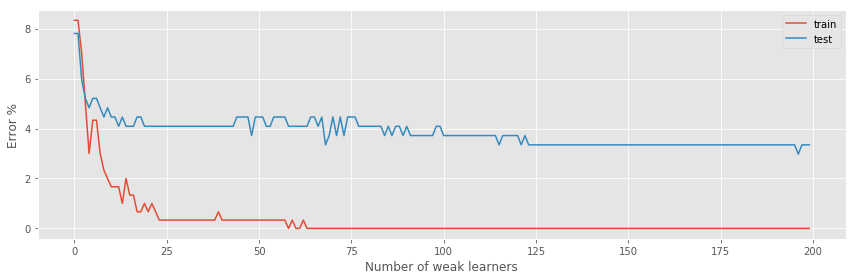

In [12]:
# Plot the train and test error
plt.figure(figsize=(12,4))
axes = plt.gca()
plt.plot(np.array(train_errors)*100, label='train')
plt.plot(np.array(test_errors)*100, label='test')
plt.xlabel('Number of weak learners')
plt.ylabel('Error %')
plt.tight_layout()
plt.legend()
plt.show()

> **How does the training error evolve?** 
>> Decreases to 0%

> **How does the test error evolve?**
>> Decreases to 2.97%

> **Compare to what you expected.**
>> Follows expectations.

> **In addition to this: which of the following statements are true?**
- A: The ensemble overfits as the complexity is increased by adding more weak learners.
- B: The ensemble underfits and more weak learners are needed to prevent this.
- C: Since there is a large gap between the training and testing accuracy, the test data clearly does not come from the same data distribution as the train data.
- D: None of the above.
>>Answer: D
>
>Not A because: To prevent overfitting, since the complexity of the overall learner increases at each step. Starting with weak learners implies the final classifier will be less likely to overfit.<br/>
Source: https://www.analyticsvidhya.com/blog/2017/09/30-questions-test-tree-based-models/

## Question 6: Feature importance

A nice additional property of AdaBoost is that it automatically does feature
selection as well (=it indicates which variables are important to make a good prediction). This is very useful when your data is high dimensional but only a couple of dimensions contain predictive information.

Look at the unique indices (dimensions) you stored in the second column of the variable $\texttt{classifiers}$. Since
you trained more classifiers than there are dimensions, the algorithm obviously
used some dimensions multiple times.
> **How many unique dimensions of the data did the algorithm actually use? Did all features get used?**

In [13]:
unique_indices = np.unique(classifiers[:,1])
print('The unique indices: {}'.format(unique_indices))
amount_unique_indices = len(unique_indices)
print('The amount of unique indices: {}'.format(amount_unique_indices))

The unique indices: [ 1.  3.  4.  6.  7.  8. 10. 11. 12. 13. 14. 17. 20. 21. 22. 23. 24. 26.
 27. 28.]
The amount of unique indices: 20


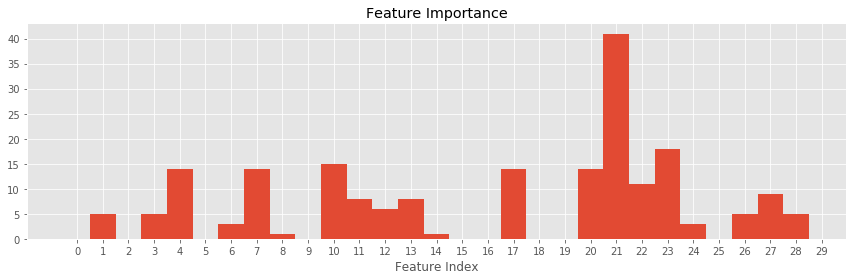

In [14]:
# The following figure also plots the frequency of each dimension
plt.figure(figsize=(12,4))
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.hist(classifiers[:,1], bins=range(number_of_dimensions), align='left')
plt.xticks(range(number_of_dimensions))
plt.tight_layout()
plt.show()

## 2. Bagging

Another method to create diversity is called Bagging or bootstrap
aggregating. To apply Bagging, one uniformly samples $M$ datasets of $\hat{N}$
datapoints from the actual dataset of $N$ points, trains a different classifier on each of
these datasets and finally averages the predictions these classifiers make on
new unseen data.
As base learner we will now use a decision tree.

![Bagging Ensemble](bagging.png)

## Question 7: Single decision tree

> First, calculate the train and test error you find using a single decision tree that has been trained on all the train data. Subsequently, apply bagging for $\hat{N}=50$ and $M=1000$ and write down the result you obtain on the test set as well.
Sample the datasets without replacement.

In [15]:
from sklearn.tree import DecisionTreeClassifier
# Make a decision tree
tree = DecisionTreeClassifier()
# Train tree
tree.fit(train_data, train_labels)
output_training = tree.predict(train_data)
train_error = sum(output_training != (train_labels[:,0])) / number_of_training_samples
print('1 Decision Tree, Train Error: {0: .3f} % '.format(train_error*100))
# Evaluate the tree on the test set and report the error in output_test
output_test = tree.predict(test_data)
test_error = sum(output_test != (test_labels[:,0]))/ number_of_test_samples
print('1 Decision Tree, Test Error:  {0: .3f} %'.format(test_error*100))

1 Decision Tree, Train Error:  0.000 % 
1 Decision Tree, Test Error:   7.063 %


## Question 8: Implementing bagging


Now let's implementing bagging and create an ensemble of trees.

In [17]:
# Do bagging
# Set the number of trees
number_of_trees = 1000 #25#
size_of_bag = 50

trees = []
# Train this many trees
for iteration in range(0,number_of_trees): 
    # Select a random subset of the training data (Hint: use np.random.choice function)
    selected_samples_indices = np.random.choice(len(train_data), size_of_bag, replace=False)  
    
    # Build and train a decision tree on the selected subset
    tree = DecisionTreeClassifier()
    # Train the tree
    tree.fit(train_data[selected_samples_indices], train_labels[selected_samples_indices])
  
    # Store the tree for later usage
    trees.append(tree)
    

# Prediction with all the trees
predictions_train = np.zeros(number_of_training_samples)
predictions_test = np.zeros(number_of_test_samples)

# Obtain predictions for the ensemble (aggregating predictions of individual trees)
for tree in trees:
    predictions_train += tree.predict(train_data)
    predictions_test += tree.predict(test_data)

# Make final prediction
output_train = np.sign(predictions_train)
output_test = np.sign(predictions_test)

# Print errors
print('Bagging with {0} trees, Train Error:{1: .3f} %'.format(number_of_trees, (sum(output_train != (train_labels[:,0])))*100 / number_of_training_samples))
print('Bagging with {0} trees, Test Error: {1: .3f} %'.format(number_of_trees, (sum(output_test != (test_labels[:,0])))*100 / number_of_test_samples))

Bagging with 1000 trees, Train Error: 1.667 %
Bagging with 1000 trees, Test Error:  5.576 %


>Bagging with 25 trees, Train Error: 3.667 %<br/>
Bagging with 25 trees, Test Error:  5.948 %

>Bagging with 1000 trees, Train Error: 1.667 %<br/>
Bagging with 1000 trees, Test Error:  5.576 %

## Question 9: Train and test error evolution with number of trees


> **Now run the code above for 1000 trees. Next run the following code below which visualizes how the training and test error evolve.**


> Take your time and observe the plot. Then proceed by describing what you see and what you would expect.

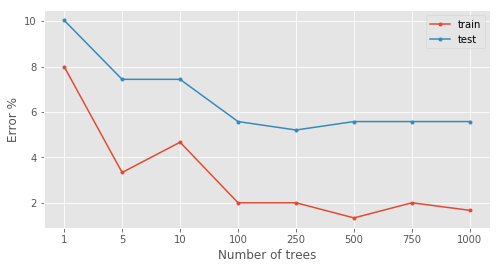

In [18]:
if (len(trees) <1000):
    print('Set trees in code above to 1000 and retrain the ensemble!')
    raise ValueError()
    
number_of_trees = [1,5,10,100,250,500,750,1000]
train_error = []
test_error = []

for n in number_of_trees:
    predictions_train = np.zeros(number_of_training_samples)
    predictions_test = np.zeros(number_of_test_samples)

    for tree in trees[:n]:
        predictions_train += tree.predict(train_data)
        predictions_test += tree.predict(test_data)

    output_train = np.sign(predictions_train)
    output_test = np.sign(predictions_test)


    train_error.append((sum(output_train != (train_labels[:,0]))) / number_of_training_samples)
    test_error.append((sum(output_test != (test_labels[:,0]))) / number_of_test_samples)

plt.figure(figsize=(8,4))
plt.plot(np.array(train_error)*100, label='train', marker='.')
plt.plot(np.array(test_error)*100, label='test',marker='.')
plt.ylabel('Error %')
plt.xlabel('Number of trees')
plt.xticks(range(len(number_of_trees)), number_of_trees)
plt.legend()
plt.show()

> **How does the training error evolve? How does the test error evolve?** 
>>Answer: Error rates decrease when #trees increase

> **Compare to what you expected.**
>> Follows expectations.